<a href="https://colab.research.google.com/github/BrentBrightwell/SenSIP/blob/main/Neural_Net_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
import itertools

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns

In [ ]:
#convert data to torch tensors
class Data(Dataset):
  def __init__(self, X, y) :
    self.X = torch.from_numpy(X.astype(np.float32))
    self.y = torch.from_numpy(y.astype(np.float32))
    self.len = self.X.shape[0]

  def __getitem__(self, index) :
    return self.X[index], self.y[index]

  def __len__(self) :
    return self.len
    
#neuralnetwork using ReLU model
class NeuralNetwork(nn.Module) :
  def __init__(self, input_dim, hidden_dim, output_dim) :
    super(NeuralNetwork, self).__init__()
    self.layer_1 = nn.Linear(input_dim, hidden_dim)
    nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
    self.layer_2 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
      x = torch.nn.functional.relu(self.layer_1(x))
      x = torch.nn.functional.sigmoid(self.layer_2(x))
      return x

In [ ]:
rs = 26

#create dataset with n samples
X, y = make_moons(n_samples = 1000, noise= 0.5, random_state=rs)
#split dataset randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=rs)

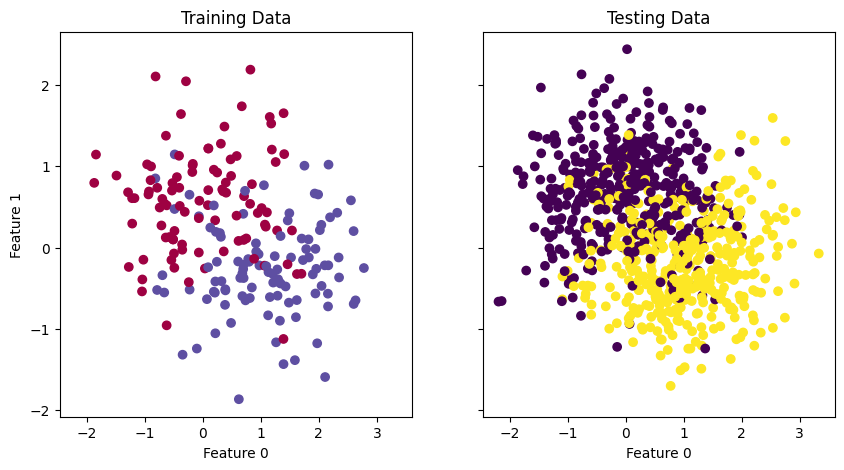

In [ ]:
#visualize data
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize = (10,5))
train_ax.scatter(X_train[:, 0], X_train[:,1], c=y_train, cmap=plt.cm.Spectral)
train_ax.set_title("Training Data")
train_ax.set_xlabel("Feature 0")
train_ax.set_ylabel("Feature 1")

test_ax.scatter(X_test[:,0], X_test[:,1], c=y_test)
test_ax.set_title("Testing Data")
test_ax.set_xlabel("Feature 0")
plt.show()

In [ ]:
batch_size = 64

#Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)


#Check it's working
for batch, (X, y) in enumerate(train_dataloader):
  print(f"Batch: {batch+1}")
  print(f"X shape: {X.shape}")
  print(f"y shape: {y.shape}")
  break

Batch: 1
X shape: torch.Size([64, 2])
y shape: torch.Size([64])


In [ ]:
#nueral network dimensions
input_dim = 2
hidden_dim = 10
output_dim =1

model = NeuralNetwork(input_dim, hidden_dim, output_dim)
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)


In [ ]:
learning_rate = 0.05
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
  for X, y in train_dataloader :
    #zero the parameter gradients
    optimizer.zero_grad()

    #forward + backward + optimize
    pred = model(X)
    loss = loss_fn(pred, y.unsqueeze(-1))
    loss_values.append(loss.item())
    loss.backward()
    optimizer.step()

print("Training Complete")

Training Complete


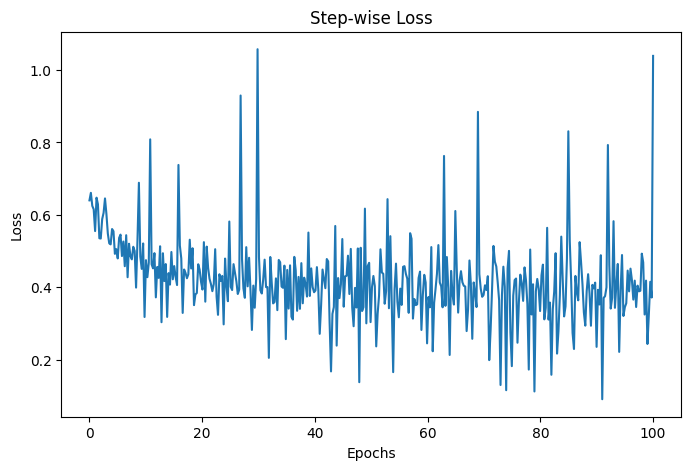

In [ ]:
step = np.linspace(0, num_epochs, len(loss_values))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Accuracy of the network on the test instances: 81%
[[354  49]
 [101 296]]


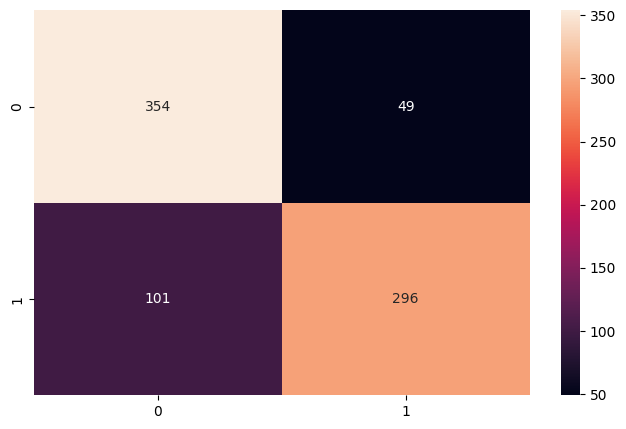

In [ ]:
correct = 0
total = 0
y_pred =[]
y_test =[]

with torch.no_grad() :
  for X, y in test_dataloader :
    outputs = model(X)
    predicted = np.where(outputs < 0.5, 0, 1)
    predicted = list(itertools.chain(*predicted))
    y_pred.append(predicted)
    y_test.append(y)
    total += y.size(0)
    correct += (predicted == y.numpy()).sum().item()

print(f'Accuracy of the network on the test instances: {100*correct //total}%')

y_pred = list(itertools.chain(*y_pred))
y_test = list(itertools.chain(*y_test))


cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
#print(classification_report(y_test, y_pred))

plt.subplots(figsize=(8, 5))
sns.heatmap(cf_matrix, annot=True, cbar=True, fmt="g")
plt.show()